# Basics of Mobile Robotics: Project

In [1]:
import time
from src import vision, pathfinder, navglobal, navlocal, thymio, draw, filtering
import numpy as np

## 1. Setting up vision

In [2]:
source = vision.WebcamSource(builtin=False)
tools = vision.VisionTools()

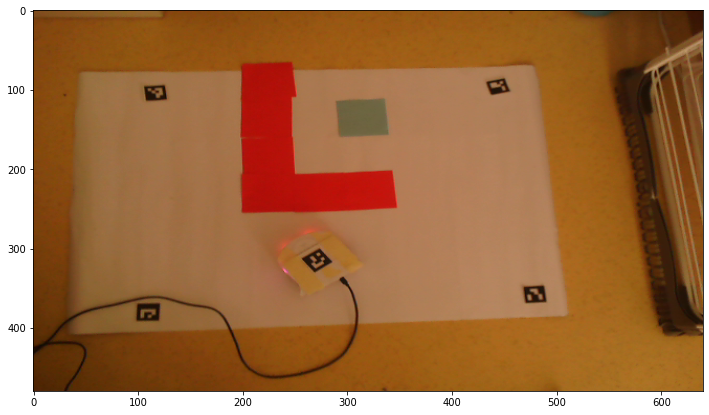

In [3]:
draw.plot_image(source.get_frame())

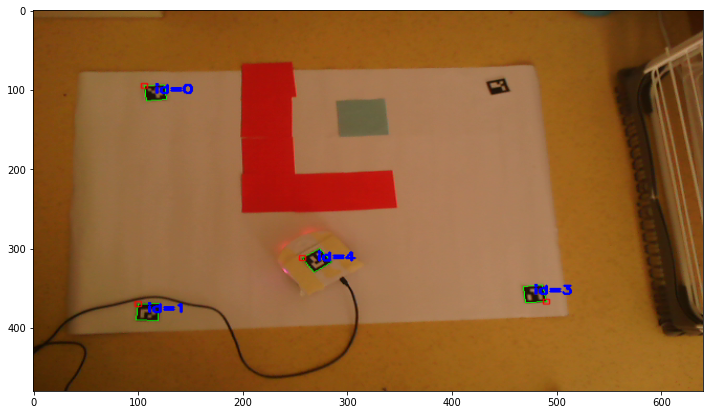

In [4]:
draw.display_aruco_markers(source, tools)

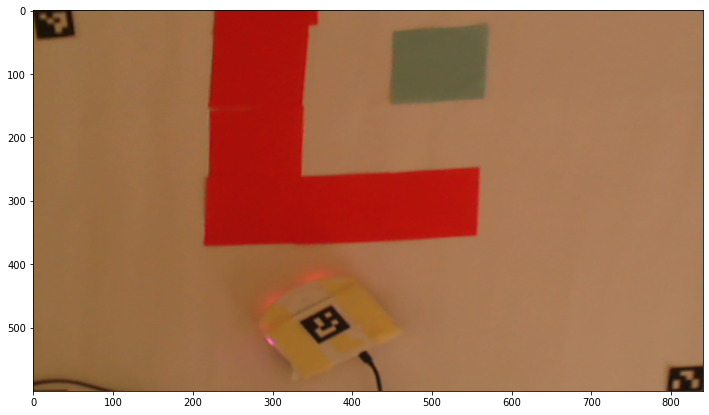

In [5]:
ready = False
while not ready:
    img = source.get_frame()
    corners_by_id = tools.get_aruco_dict(img)
    try:
        calibrated = tools.get_aruco_calibrated(img, corners_by_id)
        ready = True
    except:
        ready = False
draw.plot_image(calibrated)

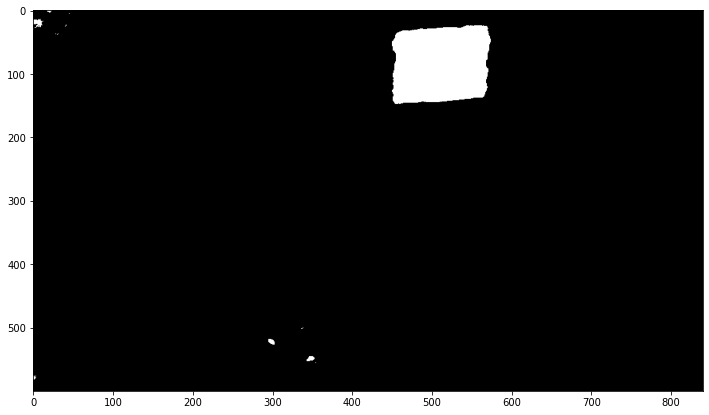

In [6]:
blue_bounds=vision.HSVBound(lb=np.array([18, 0, 0]), ub=np.array([180, 255, 255]))
mask = tools.get_color_mask(calibrated, blue_bounds)
draw.plot_image(mask)

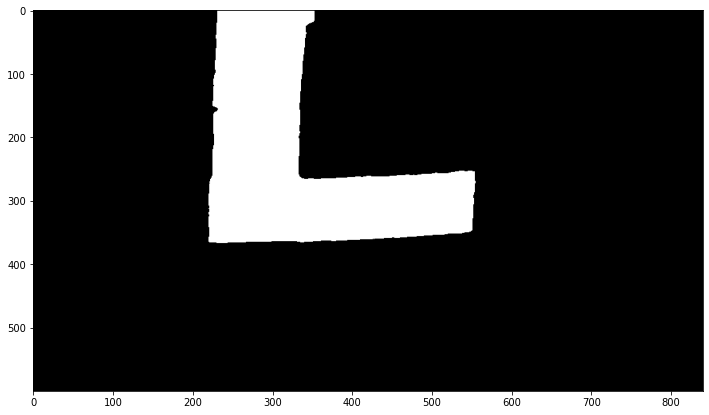

In [7]:
red_bounds=vision.HSVBound(lb=np.array([0, 230, 90]), ub=np.array([180, 255, 255]))
mask = tools.get_color_mask(calibrated, red_bounds)
draw.plot_image(mask)

In [8]:
pipeline = vision.VisionPipeline(source, tools=tools, red_bounds=red_bounds, blue_bounds=blue_bounds, dilate_factor=160)

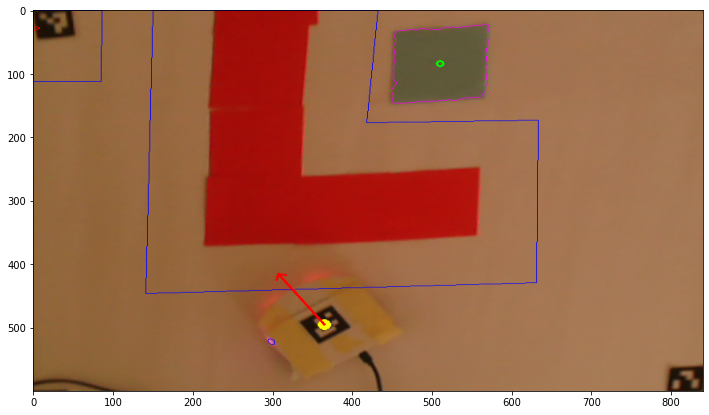

In [9]:
world = pipeline.analyze_scene()
result = pipeline.latest_frame.copy()
vision.draw_world(result, world)
draw.plot_image(result)

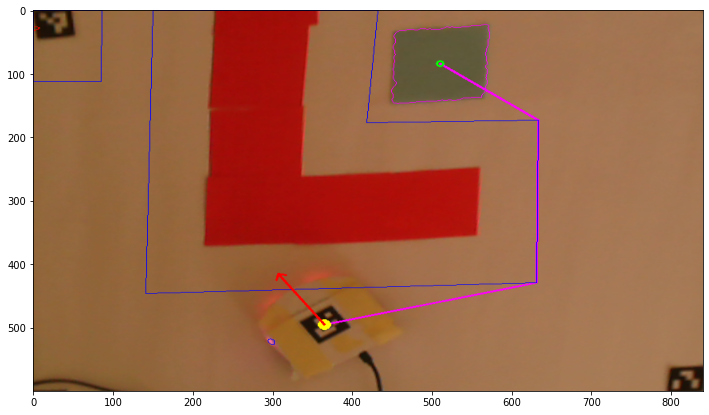

In [10]:
path = pathfinder.find_path(world)
result = pipeline.latest_frame.copy()
draw.draw_path(result, path)
vision.draw_world(result, world)
draw.plot_image(result)

In [11]:
th = thymio.Thymio()

In [12]:
navigator = navglobal.GlobalNavigation(path)
while not world.robot_at_goal(60):
    world.robot = pipeline.get_robot_pose()
    command = navigator.next_command(world.robot)
    # print(world.robot.position.distance(world.goal))
    th.process_command(command)
    # result = pipeline.latest_frame.copy()
    # vision.draw_world(result, world)
    # draw.draw_path(result, path)
    # draw.plot_image(result)
th.stop()

-1.9862374862700571
-1.8578271092223524
-1.6284754586317938
-1.4164395168276283
-1.1297787051691799
-0.9141594777288411
-0.6383072240678596
-0.3531253073361187
1.3809288774239814
1.2959500283750787
1.1008215850241303
0.9373894851787927
0.6388209498153783
0.4466295288580686
0.26199700216628763
0.21985434361402412
0.21850061079748295
0.17898033917970446
0.19135205446427417
0.24862161555366713
0.3063407510735101
0.2683324530764333
-0.2907651094454762
0.4839293114228651
0.4839293114228651
0.25046510532877475


In [13]:
th.stop()

In [ ]:
# sensor_data = th.read_sensor_data()
# while True:
#     navlocal.avoid_obstacle(th, pipeline.get_robot_pose)
# th.stop()
# print("Done")

In [ ]:
# kalman_filter = filtering.initialise(world.robot.position.v, world.robot.angle)

# while not world.robot_at_goal(50):
#     command = navglobal.follow_path(world.robot, path)
#     sensor_readings = th.read_sensor_data()
#     world.robot = pipeline.get_robot_pose()
#     filtering.update_robot(world.robot, command, sensor_readings, kalman_filter)
#     vision.draw_world(result, world)
#     draw.draw_path(result, path)
#     draw.plot_image(result)
#     # time.sleep(0.1)
# th.stop()

In [ ]:
th.stop()


## Final run sketch

The following sketches what the final run should look like combining every module together.

In [ ]:
# world = vision.analyze_scene()
# path = pathfinder.find_path(world)
# sensor_data = thymio.read_sensor_data()

# while not world.robot_at_goal():
#     if navlocal.sees_obstacle(sensor_data):
#         command = navlocal.avoid_obstacle(sensor_data)
#     else:
#         command = navglobal.follow_path(world.robot, world.goal, path)
#     thymio.process_command(command)
#     sensors = thymio.read_sensor_data()
#     filtering.update_robot(world.robot, command, sensors)
#     time.sleep(0.1)

# print("Completed!")